# Training and Evaluation for All Features

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scipy import interp

data_folder = '../../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

cv_token_pattern = u'[^;]+'

In [2]:
def train_plot_roc(X, y, n_splits=10):
    # Trying ROC
    skf = StratifiedKFold(n_splits=n_splits)
    classifier = LogisticRegression(C=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10, 4), dpi=100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 0.25])
    plt.ylim([0.50, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (mean_fpr, mean_tpr, classifier)

In [19]:
imports = pd.read_csv(build_path('learn_imports')).set_index('link')
categories = pd.read_csv(build_path('learn_behav_categories')).set_index('link')
apis = pd.read_csv(build_path('learn_behav_api_calls')).set_index('link')
signatures = pd.read_csv(build_path('learn_signatures')).set_index('link').astype(bool)

In [20]:
big_dataset = imports.drop('malware', axis=1).join(categories.drop('malware', axis=1), how='inner', lsuffix='cat_').join(
  apis.drop('malware', axis=1), how='inner', lsuffix='apis_').join(signatures.drop('malware', axis=1)).fillna(False)

In [21]:
malware = imports[imports.malware == True].index
malware = malware.join(categories[categories.malware == True].index)
malware = malware.join(apis[apis.malware == True].index)
malware = malware.join(signatures[signatures.malware == True].index)

In [22]:
goodware = imports[imports.malware == False].index
goodware = goodware.join(categories[categories.malware == False].index)
goodware = goodware.join(apis[apis.malware == False].index)
goodware = goodware.join(signatures[signatures.malware == False].index)

In [23]:
malware_labeled = pd.read_csv(build_path('malware_labeled')).set_index('link')
malware_labeled = malware_labeled.astype(float)

In [24]:
loose_data = pd.read_csv(build_path('strict_dataset')).set_index('link').index
big_dataset = big_dataset.loc[big_dataset.index.isin(loose_data), :]

In [25]:
big_dataset.loc[big_dataset.index.isin(malware), 'malware'] = True
big_dataset.loc[big_dataset.index.isin(goodware), 'malware'] = False

In [26]:
malware = big_dataset[(big_dataset.malware == 1) & (big_dataset.index.isin(malware_labeled.index))].index
goodware = big_dataset[(big_dataset.malware == 0) & ~(big_dataset.index.isin(malware_labeled.index))].index
big_dataset = big_dataset[(big_dataset.index.isin(malware)) | (big_dataset.index.isin(goodware))]

In [27]:
# Create csv of indexes so that every classifier uses the same samples, enables comparison
big_dataset.index.to_frame().to_csv(build_path('all_samples_strict'), compression='gzip')

## Baseline Classifier
Single LR for malware vs goodware using static imports

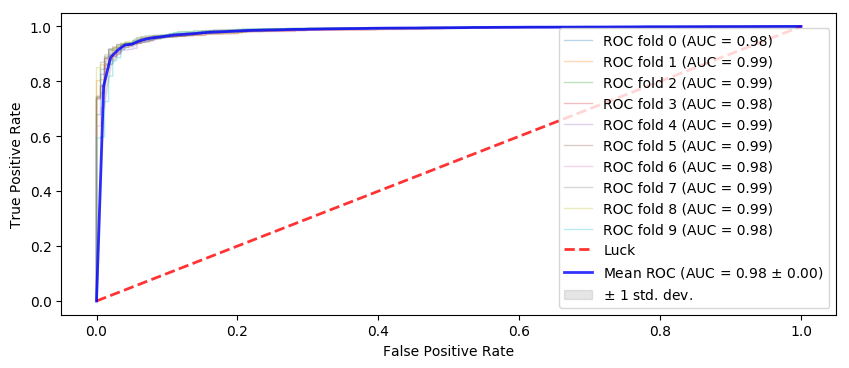

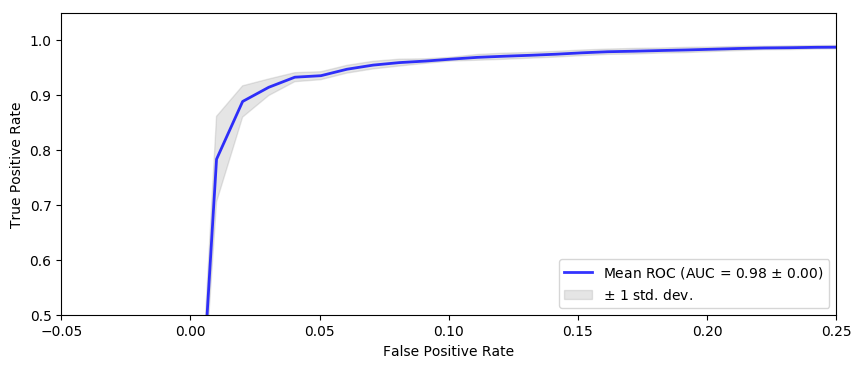

CPU times: user 50.2 s, sys: 5.34 s, total: 55.5 s
Wall time: 48.6 s


In [30]:
%%time
data = shuffle(big_dataset)
train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

## Class classifier

LR for each malware class, one-vs-all scenarios

In [31]:
mal_classes = list(malware_labeled.columns)

datasets = dict()
for mclass in mal_classes:
    mal = malware_labeled[mclass].dropna()
    datasets[mclass] = mal.index

'Testing other...'

'other: 13903'

'not other: 11275'

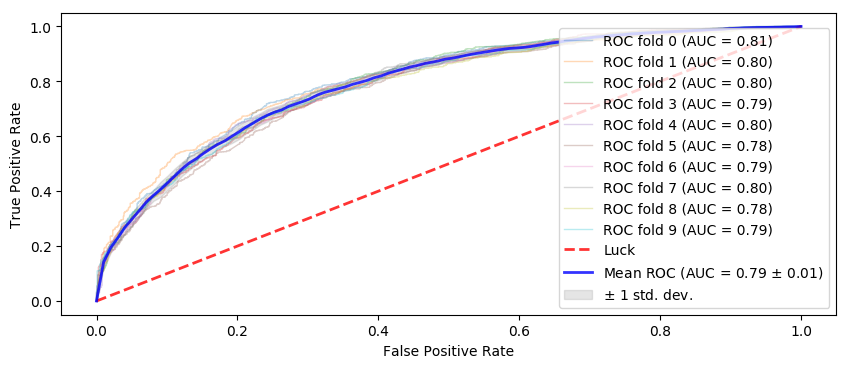

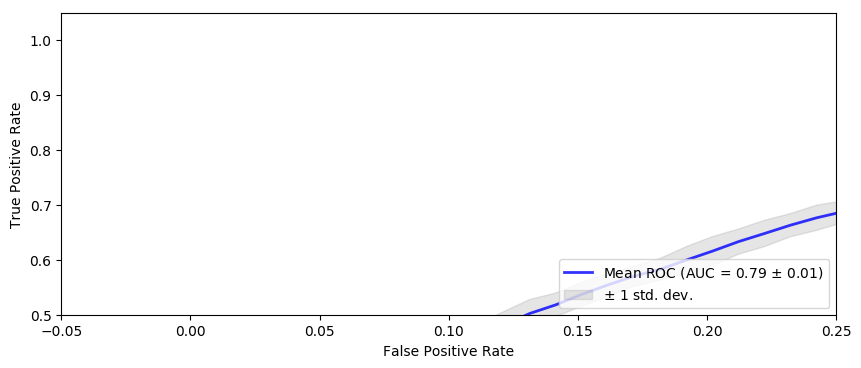

'Testing ransom...'

'ransom: 1120'

'not ransom: 24058'

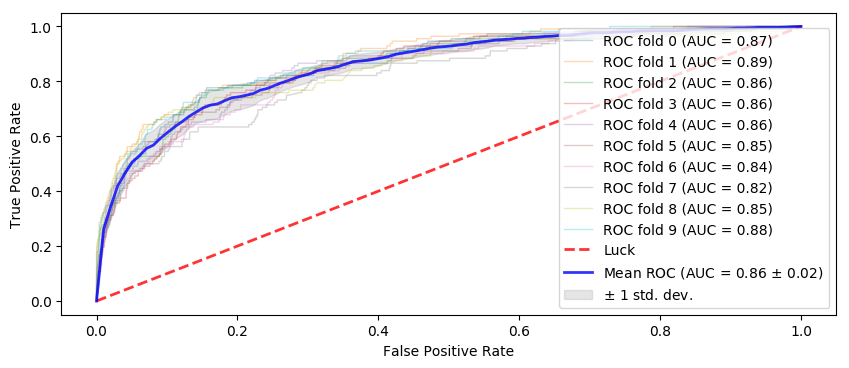

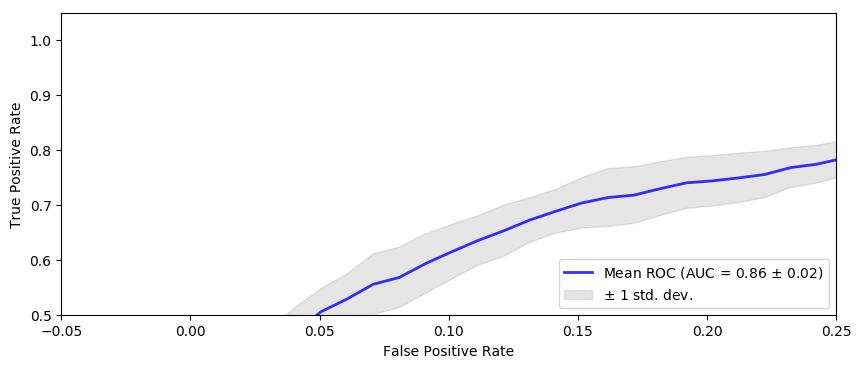

'Testing spyware...'

'spyware: 5547'

'not spyware: 19631'

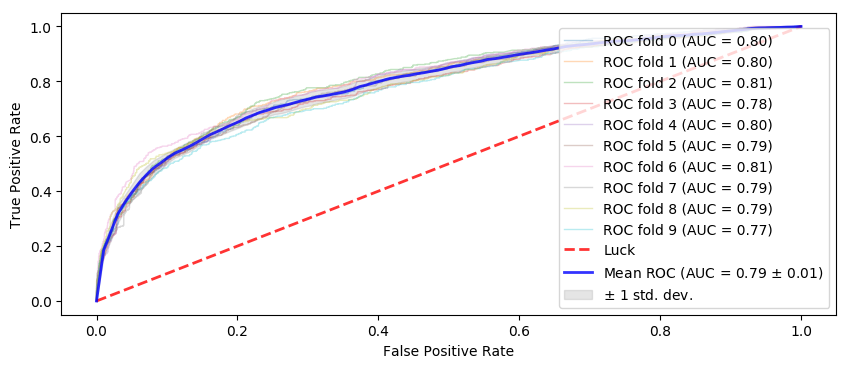

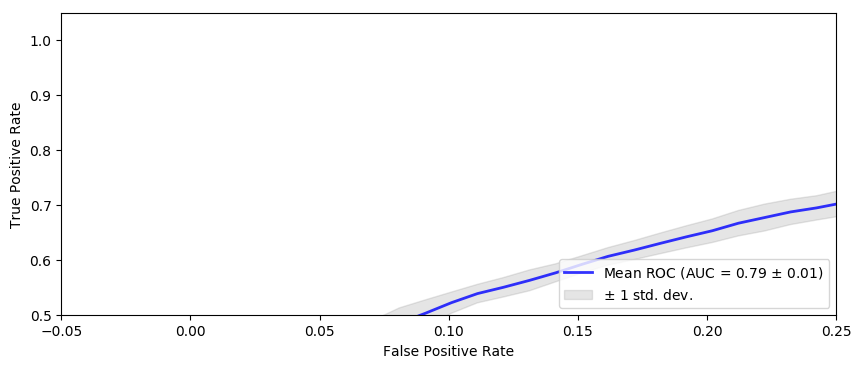

'Testing trojan...'

'trojan: 22975'

'not trojan: 2203'

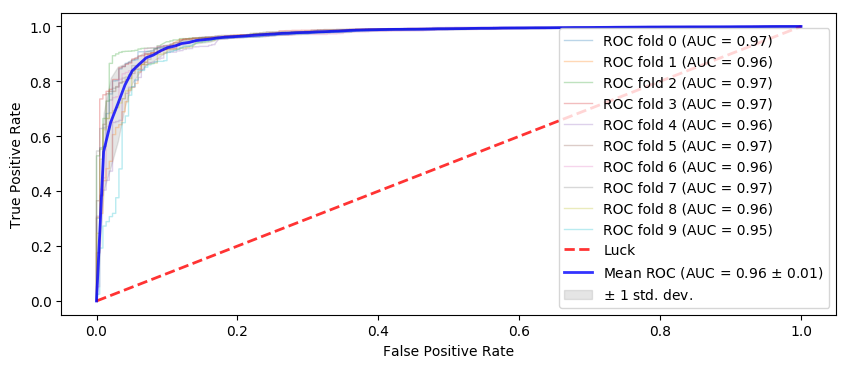

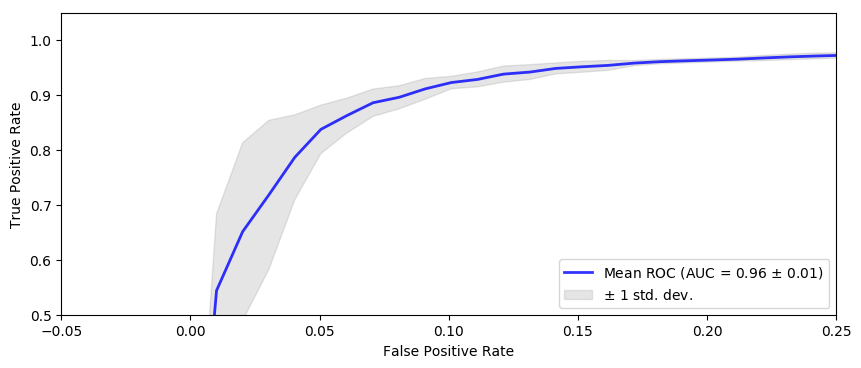

'Testing virus...'

'virus: 6605'

'not virus: 18573'

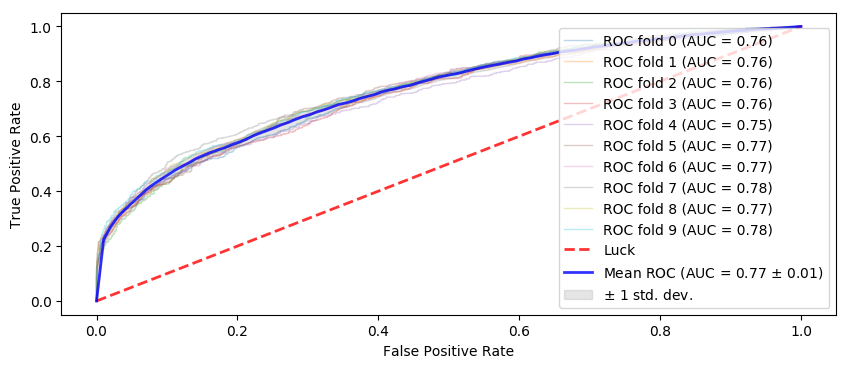

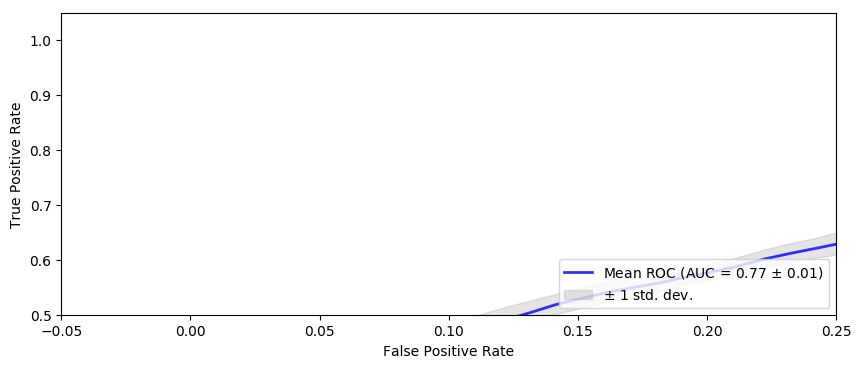

'Testing worm...'

'worm: 8974'

'not worm: 16204'

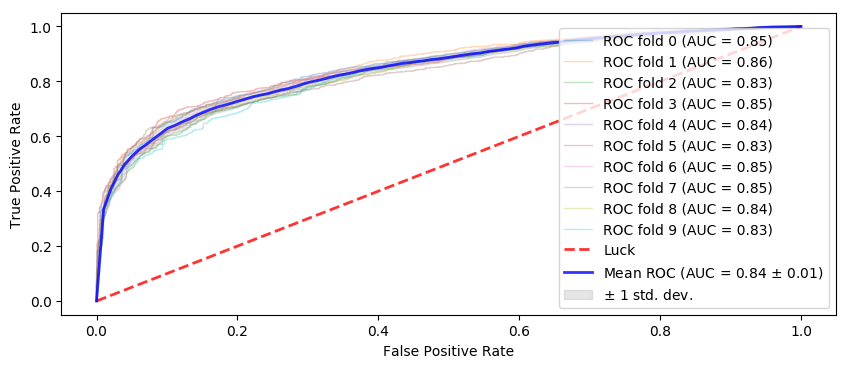

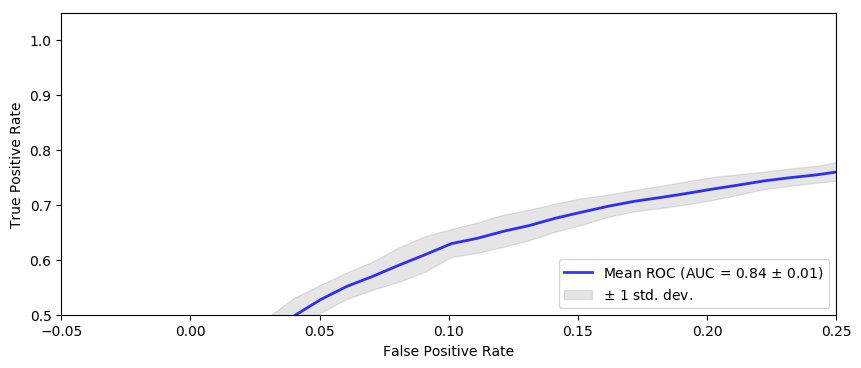

CPU times: user 9min 51s, sys: 32.5 s, total: 10min 23s
Wall time: 9min 41s


In [32]:
%%time
classifiers = dict()
final_rocs = dict()
for mclass in mal_classes:
    display('Testing {}...'.format(mclass))

    mal = big_dataset[(big_dataset.malware == True) & (big_dataset.index.isin(datasets[mclass]))]
    mal.is_copy = False
    mal.loc[:, 'malware'] = True
    not_mal = big_dataset[~(big_dataset.index.isin(datasets[mclass]))]
    not_mal.is_copy = False
    not_mal.loc[:, 'malware'] = False
    
    data = shuffle(pd.concat([mal, not_mal]))
    display('{}: {}'.format(mclass, len(mal)))
    display('not {}: {}'.format(mclass, len(not_mal)))
    assert len(big_dataset) == len(data)
    
    X = np.array(data.drop('malware', axis=1))
    y = data.malware
    mean_fpr, mean_tpr, classifier = train_plot_roc(X, y)
    final_rocs[mclass] = (mean_fpr, mean_tpr)
    classifiers[mclass] = classifier.fit(X, y)

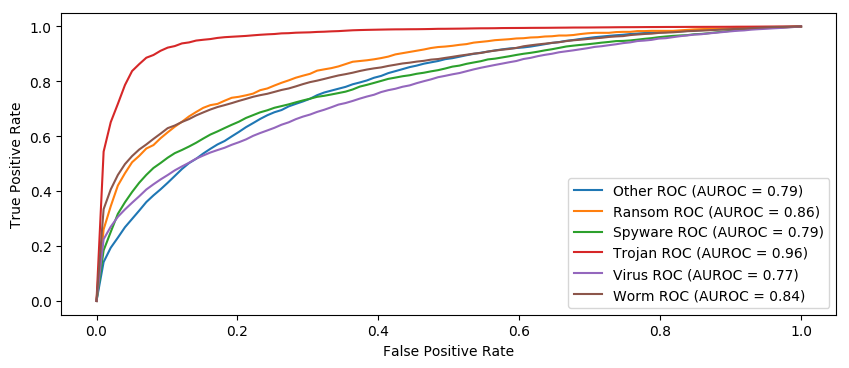

In [33]:
plt.figure(figsize=(10, 4), dpi=100)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
for mclass in mal_classes:
    plt.plot(final_rocs[mclass][0],
             final_rocs[mclass][1],
             label='{} ROC (AUROC = {:.2f})'.format(mclass.capitalize(), auc(final_rocs[mclass][0], final_rocs[mclass][1])))
plt.legend(loc="lower right")
plt.show()

## Ensemble Classifier
Joins previous classifiers into ensemble

In [34]:
# Join to big_dataset classification from smaller classifiers
X = big_dataset.drop('malware', axis=1)
big_dataset4 = pd.DataFrame(columns=mal_classes, index=big_dataset.index)
for mclass in mal_classes:
    probs = classifiers[mclass].predict_proba(X)[:,1]
    results = pd.DataFrame(index=big_dataset.index, data=classifiers[mclass].predict_proba(X)[:,1], columns=[mclass])
    big_dataset4.loc[:, mclass] = results
big_dataset4.loc[:, 'malware'] = big_dataset.malware

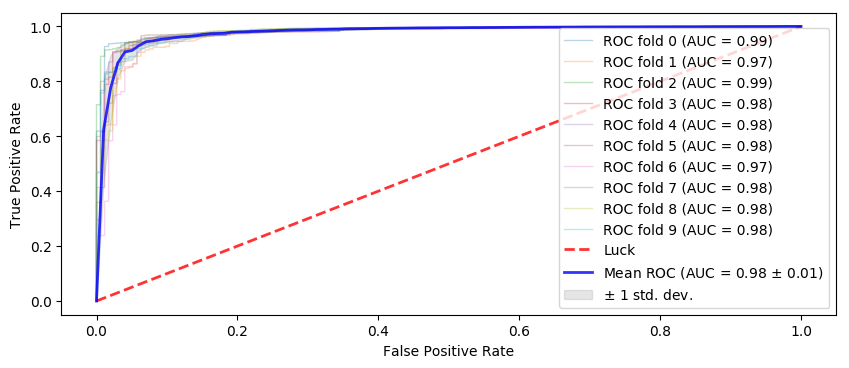

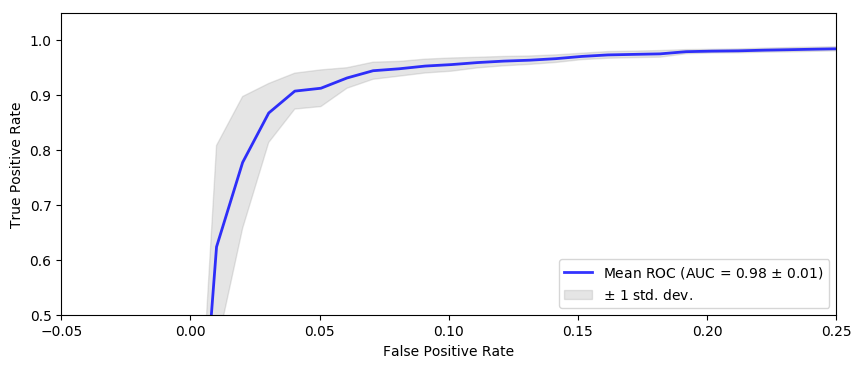

(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

In [35]:
data = shuffle(big_dataset4)
train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)